In [7]:
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


import xgboost as xgb
from xgboost import XGBClassifier

In [6]:
from main import *

In [8]:
X = df3.drop(columns=['id_producto','label'], axis=1)
Y = df3['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.33, random_state=42)

In [3]:
xgbmodel = XGBClassifier()
xgbmodel.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [5]:
params={ 'base_score': [0.5], # prediccion inicial
         #'booster': ['gbtree'],# (gbtree, gblinear, dart)
     'colsample_bylevel': [1],
     'colsample_bytree': [0.8], #aletoreidad en selección de columnas de cada arbol
     'learning_rate': [0.05,0.1], 
     'max_depth': [3], 
     'min_child_weight': [1], # minimo numero samples por hoja
     #'missing': [np.nan], # si queremos reemplazar los missings por un numero
     #'n_estimators': [100,150,200,250,300,350,400], # numero de arboles [100,150,200,250,300,350,400]
     'n_jobs': [-1], # trabajos en paralelo
     'random_state': [0], # seed para generar los folds
     'reg_alpha': [0.01], # L1 regularitacion
     'reg_lambda': [0.01], # L2 regularitacion
     'scale_pos_weight': [1],
     'subsample': [0.9]} # ratio de muestras por cada arbol 

In [9]:
scoring = ['roc_auc']
grid_solver = GridSearchCV(estimator = xgbmodel, # model to train
                   param_grid = params,
                   scoring = scoring,
                   cv = 3,
                   n_jobs=-1,
                   refit = 'roc_auc',
                   verbose = 2)

In [10]:
model_result_xgboost = grid_solver.fit(X_train,y_train)
model_result_xgboost.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_jobs': -1,
 'random_state': 0,
 'reg_alpha': 0.01,
 'reg_lambda': 0.01,
 'scale_pos_weight': 1,
 'subsample': 0.9}

In [11]:
#Ahora todos los modelos los usamos con la data train para obtener las probabilidades
y_pred = model_result_xgboost.predict(X_train)
probs = model_result_xgboost.predict_proba(X_train)
print('Train AUC:', roc_auc_score(y_train,probs[:,1]))

#Ahora evaluo el resultado con la data de test
y_pred = model_result_xgboost.predict(X_test)
probs = model_result_xgboost.predict_proba(X_test)
print(" Test AUC:", roc_auc_score(y_test,probs[:,1]))

Train AUC: 0.9752960015771908
 Test AUC: 0.9642282646386402


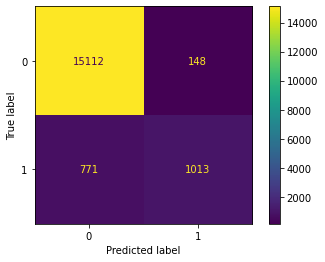

In [12]:
y_pred = model_result_xgboost.predict(X_test)
probs = model_result_xgboost.predict_proba(X_test)
#plot_confusion_matrix(model_result,  X_test, y_test) funcion deprecada en futuras versiones
cm = confusion_matrix(y_test,y_pred)
disp =ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_result_xgboost.classes_)
disp.plot()
plt.show()

In [13]:
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:,1])
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

0.9642282646386402


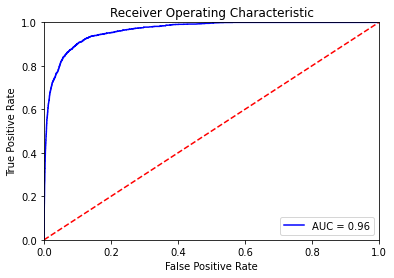

In [14]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
print(classification_report(y_test,y_pred,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     15260
           1       0.87      0.57      0.69      1784

    accuracy                           0.95     17044
   macro avg       0.91      0.78      0.83     17044
weighted avg       0.94      0.95      0.94     17044

